In [7]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
from random import random
from scipy import special

# Read data

In [3]:
num_agent = 1000
num_trials = 720
data = pd.read_csv(f'data/hrl_rmus/{num_agent}agent_{num_trials}t_HRL.csv')

In [4]:
parameters = data.groupby('agentid')[['alpha', 'beta']].mean()
grouped_data = data.groupby('agentid').agg({
    'chosenside': list,
    'chosencue': list,
    'rewards': list,
    'allstims0': list,
    'allstims1': list,
    'allstims2': list,
    'isswitch': list,
    'rpe_history': list,
}).reset_index()
grouped_data.head(4)

,agentid,chosenside,chosencue,rewards,allstims0,allstims1,allstims2,isswitch,rpe_history
0,0,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...","[0, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.3333333333333333, 0.3439237684979518, -0.8..."
1,1,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, ...","[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...","[0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.3333333333333333, 0.2677979939078989, 0.10..."
2,2,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, ...","[2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 2, 1, 1, 2, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.3333333333333333, 0.3218117282083748, 0.15..."
3,3,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 2, 1, 1, 1, 2, ...","[1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.6666666666666667, 0.2255539227997106, 0.076..."


# HMMParticleFilter

In [5]:
#@title HMMParticleFilter
class HMMParticleFilter:
    def __init__(self, alpha, beta, n_particles, n_states, initial_state_probs=None):
        """
        Initialize Particle Filter for HMM

        Args:
            n_particles: Number of particles
            n_states: Number of hidden states
            transition_matrix: State transition probability matrix (n_states x n_states)
            emission_means: Mean of Gaussian emission for each state
            emission_stds: Standard deviation of Gaussian emission for each state
            initial_state_probs: Initial state probabilities
        """
        self.n_particles = n_particles
        self.n_states = n_states

        # Initialize initial state probabilities if not provided
        if initial_state_probs is None:
            self.initial_state_probs = np.ones(n_states) / n_states
        else:
            self.initial_state_probs = initial_state_probs

        # Initialize particles and weights
        self.particles = np.random.choice(n_states, size=n_particles,
                                        p=self.initial_state_probs)
        self.weights = np.ones(n_particles) / n_particles
        self.q_values = (1/n_states)*np.ones((n_particles, n_states))

        # Storage for state estimates
        self.state_estimates = []
        self.state_probabilities = []
        self.beta = beta
        self.alpha = alpha
        
    def predict_action(self, state, particle_idx):
        """Predict action probabilities for a given particle"""
        sftmx_p = special.softmax(self.beta * self.q_values[particle_idx])
        return sftmx_p #self.softmax(self.q_values[particle_idx], self.beta)

    def predict(self):
        """
        Predict step: propagate particles through transition model
        """
        new_particles = np.zeros(self.n_particles, dtype=int)
        for i in range(self.n_particles):
            # Sample new state from transition probabilities
            txp = self.predict_action(None, i) #self.q_values[i] / np.sum(self.q_values[i])
            new_particles[i] = np.random.choice(self.n_states, p=txp)

        self.particles = new_particles

    def update(self, reward, action, stim):
        """
        Update step: update weights based on observation

        Args:
            observation: Current observation
        """
        # Find unique values, their first occurrence indices, and frequency counts
        unique_values, indices, counts = np.unique(stim, return_index=True, return_counts=True)

        # Filter to get values and indices that appear only once
        unique_action = unique_values[counts == 1]
        unique_arrow = indices[counts == 1]
        # Calculate emission probabilities for all particles
        for i in range(self.n_particles):
            bandit_probs = self.predict_action(None, i)
            arrow = self.particles[i]
            # not possible if chosen arrow direction is not the same as action
            if action != stim[arrow]:
              prob = 0
            elif action == unique_action: # following the unique side color 
              prob = 1
            # if action == unique_action: # following the unique side color
            #   prob = 0 if arrow != unique_arrow else 1 #bandit_probs[arrow]
            # elif arrow == unique_arrow: # not choosing unique action but follow unique side color - not possible
            #   prob = 0
            else:
              prob = bandit_probs[arrow]/(1-bandit_probs[unique_arrow])

            self.weights[i] *= prob

            # Calculate RPE for this particle
            rpe = reward - self.q_values[i, arrow]
            # Update Q-values using particle's learning rate
            self.q_values[i, arrow] += self.alpha * rpe
            # update the q value of other cues (counterfactual learning)
            others = np.array([x for x in list(np.arange(self.n_states)) if x != arrow ])
            self.q_values[i, others] += self.alpha*((1-reward)-self.q_values[i, others])

        # Normalize weights
        if np.sum(self.weights) > 0:
            self.weights /= np.sum(self.weights)
        else:
            # Handle numerical underflow
            self.weights = np.ones(self.n_particles) / self.n_particles

    def estimate_state(self):
        """
        Estimate current state from particle distribution

        Returns:
            most_likely_state: Most likely current state
            state_probs: Probability distribution over states
        """
        state_counts = np.zeros(self.n_states)

        for i in range(self.n_particles):
            state_counts[self.particles[i]] += self.weights[i]

        state_probs = state_counts / np.sum(state_counts)
        most_likely_state = np.argmax(state_probs)

        return most_likely_state, state_probs

    def resample(self):
        """
        Resample particles based on their weights using systematic resampling
        """
        positions = (np.random.random() + np.arange(self.n_particles)) / self.n_particles
        cumulative_sum = np.cumsum(self.weights)

        # Handle numerical errors
        cumulative_sum[-1] = 1.0

        # Create new particles array
        new_particles = np.zeros(self.n_particles, dtype=int)

        i = 0  # positions index
        j = 0  # cumulative sum index

        while i < self.n_particles:
            if positions[i] < cumulative_sum[j]:
                new_particles[i] = self.particles[j]
                i += 1
            else:
                j += 1

        self.particles = new_particles
        self.weights = np.ones(self.n_particles) / self.n_particles

    def filter(self, reward, action, stimuli):
        """
        Perform one complete step of particle filtering

        Args:
            observation: Current observation

        Returns:
            most_likely_state: Most likely current state
            state_probs: Probability distribution over states
        """
        # Predict step
        self.predict()

        # Update step
        self.update(reward, action, stimuli)

        # Calculate effective sample size ESS = 1 / Σ(w_i^2)
        # This is a common heuristic used in particle filters to 
        # determine when the particle diversity has become too low and 
        # resampling is needed to maintain a good approximation of the
        # true state distribution.
        n_eff = 1.0 / np.sum(self.weights ** 2)

        # Resample if effective sample size is too low
        if n_eff < self.n_particles / 2:
          self.resample()

        # Estimate state
        most_likely_state, state_probs = self.estimate_state()

        # Store estimates
        self.state_estimates.append(most_likely_state)
        self.state_probabilities.append(state_probs)

        return most_likely_state, state_probs

# Run PF

In [19]:
res = {
    'id': [],
    'pred': [],
    'true': [],
    'pred_prob': [],
}

start_time = time.time()
for i in range(len(grouped_data)):
  if i < 50:
    continue
  elif i == 200:
    break
  
  print(f'agent {i}...')
  a = parameters['alpha'][i]
  b = parameters['beta'][i]
  pf = HMMParticleFilter(alpha=a, beta=b, n_particles=1000, n_states=3)
  actions = grouped_data['chosenside'][i]
  rewards = grouped_data['rewards'][i]
  # Run particle filter
  estimated_states = []
  state_probabilities = []
  array = np.vstack([grouped_data['allstims0'][i], grouped_data['allstims1'][i], grouped_data['allstims2'][i]])
  stimuli = np.swapaxes(array, 0, 1)
  for (action, reward, stim) in zip(actions, rewards, stimuli):
      est_state, state_probs = pf.filter(reward, action, stim)
      estimated_states.append(est_state)
      state_probabilities.append(state_probs)

  res['id'].append(i)
  res['pred'].append(estimated_states)
  res['true'].append(grouped_data['chosencue'][i])
  res['pred_prob'].append(state_probabilities)

# End timing
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")  

agent 50...
agent 51...
agent 52...
agent 53...
agent 54...
agent 55...
agent 56...
agent 57...
agent 58...
agent 59...
agent 60...
agent 61...
agent 62...
agent 63...
agent 64...
agent 65...
agent 66...
agent 67...
agent 68...
agent 69...
agent 70...
agent 71...
agent 72...
agent 73...
agent 74...
agent 75...
agent 76...
agent 77...
agent 78...
agent 79...
agent 80...
agent 81...
agent 82...
agent 83...
agent 84...
agent 85...
agent 86...
agent 87...
agent 88...
agent 89...
agent 90...
agent 91...
agent 92...
agent 93...
agent 94...
agent 95...
agent 96...
agent 97...
agent 98...
agent 99...
agent 100...
agent 101...
agent 102...
agent 103...
agent 104...
agent 105...
agent 106...
agent 107...
agent 108...
agent 109...
agent 110...
agent 111...
agent 112...
agent 113...
agent 114...
agent 115...
agent 116...
agent 117...
agent 118...
agent 119...
agent 120...
agent 121...
agent 122...
agent 123...
agent 124...
agent 125...
agent 126...
agent 127...
agent 128...
agent 129...
agent 130.

In [20]:
import pickle

pickle.dump(res, open('results/pf_results{0}.pkl'.format(150), 'wb'))

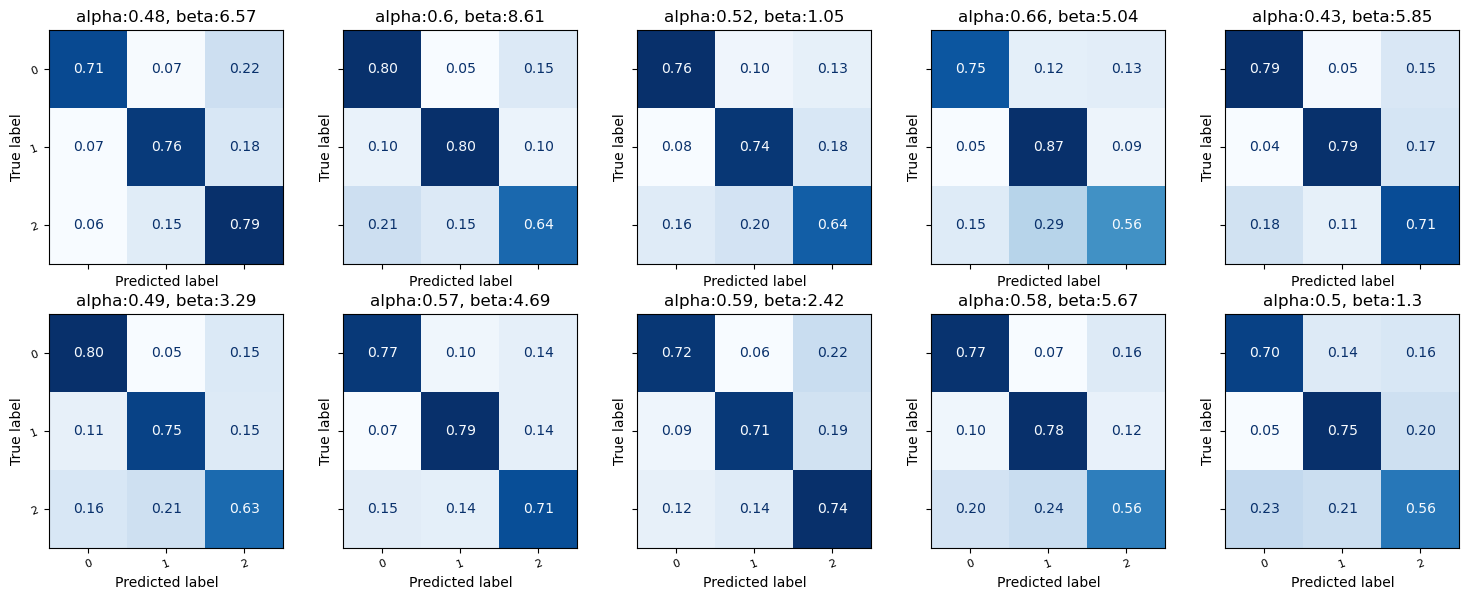

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

n_col = 5 #len(res['pred'])
n_row = 2
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row), sharex=True, sharey=True)
for i in range(n_col*n_row):
  true = np.array(res['pred'][i])
  pred = np.array(res['true'][i])

  disp = ConfusionMatrixDisplay.from_predictions(
      true,
      pred,
      cmap=plt.cm.Blues,
      colorbar=False,
      text_kw={'size': 10},
      values_format='.2f',
      ax=axes.flat[i],
      normalize='true')

  #disp.im_.set_clim(0, 1)
  disp.ax_.tick_params(axis='both', which='major', labelsize=8, rotation=20)
  a = round(parameters['alpha'][i], 2)
  b = round(parameters['beta'][i], 2)
  axes.flat[i].set_title(f'alpha:{a}, beta:{b}')
plt.tight_layout()
plt.show()

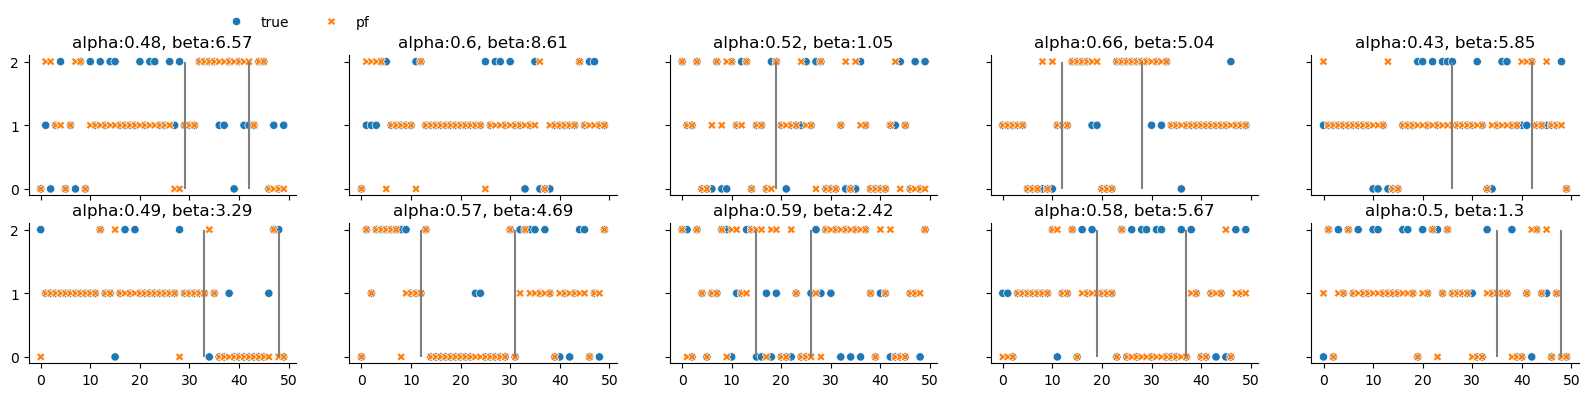

In [12]:
# Plot the results
n_col = 5 #len(res['pred'])
n_row = 2
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(4*n_col, 2*n_row), sharex=True, sharey=True)
for i in range(n_col*n_row):
  true = np.array(res['pred'][i])
  pred = np.array(res['true'][i])

  results = {'true': true[:50], 'pf': pred[:50]}
  show_legend = (i == 0)
  ax = sns.scatterplot(results, ax=axes.flat[i], legend=show_legend)
  ax.set_yticks([0, 1, 2], ['0', '1', '2'])
  switched_trials = np.argwhere(grouped_data.isswitch[i][:50])
  ax.vlines(x = switched_trials, ymin = 0, ymax = 2, color='grey')

  a = round(parameters['alpha'][i], 2)
  b = round(parameters['beta'][i], 2)
  axes.flat[i].set_title(f'alpha:{a}, beta:{b}')
  if show_legend:
    sns.move_legend(
      ax, "lower center",
      bbox_to_anchor=(1, 1.1), ncol=2, title=None, frameon=False,
    )
sns.despine()
plt.show()

In [14]:
num_agent = 20
num_arrows = data.chosencue.unique().shape[0]
true_q_data = data.groupby('agentid').agg({
    'qv0': list,
    'qv1': list,
    'qv2': list,
}).reset_index()

rpe_res = {'pred': [], 'true': []}
q_res = {f'qv{i}': [] for i in range(num_arrows)}

for i in range(num_agent):
  a = parameters['alpha'][i]
  b = parameters['beta'][i]
  actions = grouped_data['chosenside'][i]
  rewards = grouped_data['rewards'][i]
  array = np.vstack([grouped_data['allstims0'][i], grouped_data['allstims1'][i], grouped_data['allstims2'][i]])
  stimuli = np.swapaxes(array, 0, 1)
  num_arrows = stimuli.shape[-1]
  pred_arrows = res['pred'][i]

  estimated_rpe = []
  Q = np.ones(num_arrows) / num_arrows
  Qt = [[], [], []]
  for (r, stim, arrow) in zip(rewards, stimuli, pred_arrows):
    for ai in range(num_arrows):
      Qt[ai].append(Q[ai])

    # update the q value of the selected cue
    rpe = r-Q[arrow]
    estimated_rpe.append(rpe)

    Q[arrow]+= (a*rpe)
    # update the q value of other cues (counterfactual learning)
    others = np.array([x for x in list(np.arange(num_arrows)) if x!=arrow ])
    Q[others] += a*((1-r)-Q[others])

  rpe_res['pred'].append(estimated_rpe)
  rpe_res['true'].append(grouped_data['rpe_history'][i])
  for ai in range(num_arrows):
    q_res[f'qv{ai}'].append(Qt[ai]) 

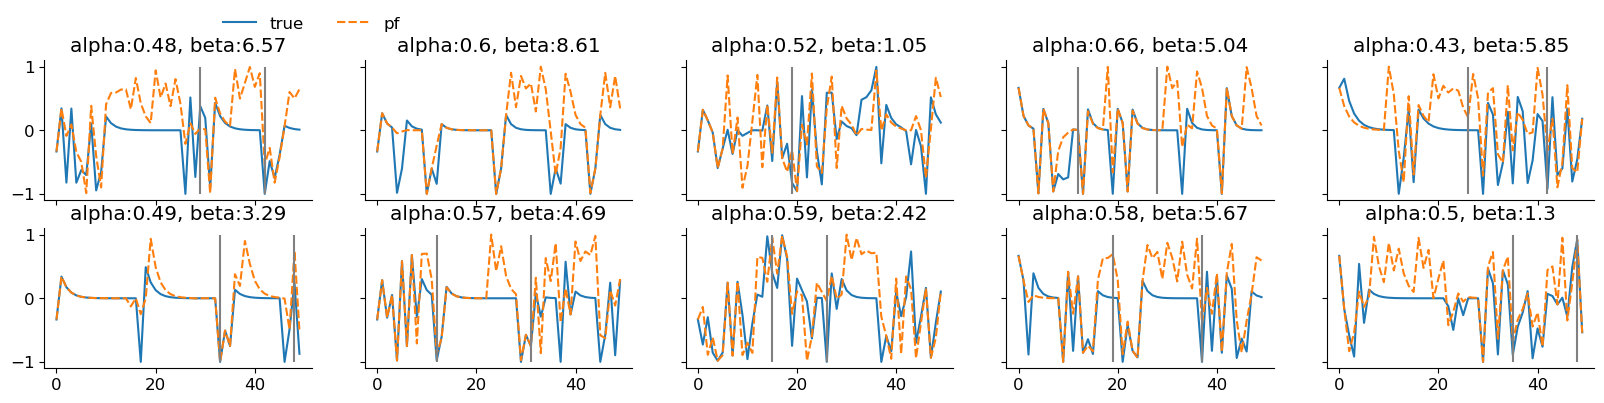

In [16]:
n_col = 5 #len(res['pred'])
n_row = 2
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(4*n_col, 2*n_row), sharex=True, sharey=True)
for i in range(n_col*n_row):
  true = np.array(rpe_res['true'][i])
  pred = np.array(rpe_res['pred'][i])

  results = {'true': true[:50], 'pf': pred[:50]}
  show_legend = (i == 0)
  ax = sns.lineplot(results, ax=axes.flat[i], legend=show_legend)
  #ax.set_yticks([0, 1, 2], ['0', '1', '2'])
  switched_trials = np.argwhere(grouped_data.isswitch[i][:50])
  ax.vlines(x = switched_trials, ymin = -1, ymax = 1, color='grey')

  a = round(parameters['alpha'][i], 2)
  b = round(parameters['beta'][i], 2)
  axes.flat[i].set_title(f'alpha:{a}, beta:{b}')
  if show_legend:
    sns.move_legend(
      ax, "lower center",
      bbox_to_anchor=(1, 1.1), ncol=2, title=None, frameon=False,
    )

sns.despine()
plt.show()

720


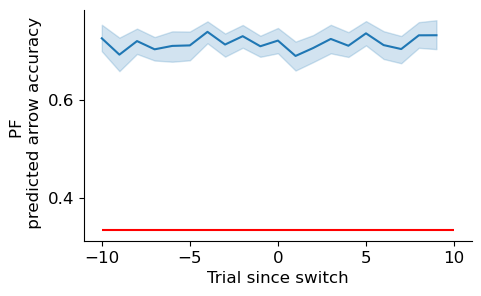

In [13]:
def acc_around_switches(true, pred, isswitch, num_pre_switch=5, num_post_switch=10):
    corr = true == pred
    corr = corr.astype(int)
    print(true.shape[-1])
    res = {'trial_since_switch': [], 'accuracy': [], 'agent_id': []}
    for i in range(true.shape[0]):
      switches = np.argwhere(isswitch[i])

      switches = [x for x in switches if x <= true.shape[-1] - num_post_switch]
      allswitchaccuracy = np.nan * np.ones(
          [len(switches), num_pre_switch + num_post_switch]
      )

      for idx in range(len(switches)):
          sw = switches[idx]
          allswitchaccuracy[idx] = np.array(
              corr[i][np.arange(sw - num_pre_switch, sw + num_post_switch)]
          )

      lc = np.nanmean(allswitchaccuracy, 0)
      x_axis = np.arange(-num_pre_switch, num_post_switch) #for x axis, trials before and after the switch
      res['trial_since_switch'].extend(x_axis)
      res['accuracy'].extend(lc)
      res['agent_id'].extend([i]*len(lc))

    return pd.DataFrame(res)

#corr = true_latent == predicted_state
num_pre_switch = 10
result = acc_around_switches(np.array(res['true']), np.array(res['pred']), grouped_data.isswitch, num_pre_switch, 10)

plt.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(5, 3))
ax = sns.lineplot(result, x='trial_since_switch', y='accuracy')
#ax.set_ylim((0.0, 1.0))
y_ticks = np.linspace(0, 1, num=6).round(2)
ax.set(yticks=y_ticks, yticklabels=y_ticks)
ax.set_ylabel('PF \n predicted arrow accuracy')
ax.set_xlabel('Trial since switch')
ax.hlines(y=(1/3), xmin = -num_pre_switch, xmax = 10, color='red')
sns.despine()